In [50]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import torch
torch.use_deterministic_algorithms(False)
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.use_deterministic_algorithms(False)

In [ ]:
# Unzip train and test
!unzip train.zip
!unzip test.zip

In [5]:

print(os.listdir('/content/train'))
print(os.listdir('/content/test'))

['urls_unsup.txt', 'unsup', 'neg', 'pos', 'urls_neg.txt', 'urls_pos.txt', 'labeledBow.feat', 'unsupBow.feat']
['neg', 'pos', 'urls_neg.txt', 'urls_pos.txt', 'labeledBow.feat']


In [7]:
# read sentiments and reviews data from the text files
review_list = []
label_list = []
for label in ['pos', 'neg']:
  for fname in tqdm(os.listdir(
    f'/content/train/{label}/')):
    if 'txt' not in fname:
      continue
    with open(os.path.join(f'/content/train/{label}/',
    fname), encoding="utf8") as f:
      review_list += [f.read()]
      label_list += [label]
print ('Number of reviews :', len(review_list))

100%|██████████| 12500/12500 [00:00<00:00, 47149.86it/s]

Number of reviews : 25000


In [8]:
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review
if letter not in punctuation])
for review in tqdm(review_list)]
# accumulate all review texts together
reviews_blob = ' '.join(review_list)
# generate list of all words of all reviews
review_words = reviews_blob.split()
# get the word counts
count_words = Counter(review_words)
# sort words as per counts (decreasing order)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)
print(sorted_review_words[:10])

100%|██████████| 25000/25000 [00:01<00:00, 15120.31it/s]


[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


In [9]:
# create word to integer (token) dictionary
# in order to encode text as numbers
vocab_to_token = {word:idx+1 for idx,
(word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


In [21]:
reviews_tokenized = []
for review in review_list:
  word_to_token = [vocab_to_token[word] for word in
review.split()]
  reviews_tokenized.append(word_to_token)
print(review_list[0])
print()
print (reviews_tokenized[0])

when i first found out that brian krause was going to be in this movie i wanted to watch it took me weeks to realize that ive seen the original of this and loved it so i had even more reason to watch well i watched it was actually better than most sequels for tv movies i hate what happens to brians character you can find out for yourself and i didnt like most of the characters brians one included but the movie needed the cheesy and annoying and jerklike characters to make stanley caldwell judd nelson shine once more at the end i was cheering for stanley and his own happy ending if you liked the original cabin by the lake or if you like horror movies without the blood id suggest you watch this

[50, 9, 85, 248, 45, 11, 1584, 14098, 13, 165, 5, 27, 7, 10, 17, 9, 452, 5, 103, 8, 539, 69, 2383, 5, 886, 11, 194, 107, 1, 197, 4, 10, 2, 433, 8, 37, 9, 66, 53, 51, 274, 5, 103, 73, 9, 283, 8, 13, 155, 124, 70, 87, 2212, 15, 243, 92, 9, 780, 48, 556, 5, 20049, 108, 22, 68, 159, 45, 15, 625, 2, 9

In [23]:
# encode sentiments as 0 or 1
encoded_label_list = [1 if label =='pos'
else 0 for label in label_list]
reviews_len = [len(review) for review in reviews_tokenized]
reviews_tokenized = [reviews_tokenized[I]
for I, l in enumerate(reviews_len)
if l>0 ]
encoded_label_list = np.array([encoded_label_list[I]
for I, l in enumerate(reviews_len)
if l> 0 ], dtype=np.float32)

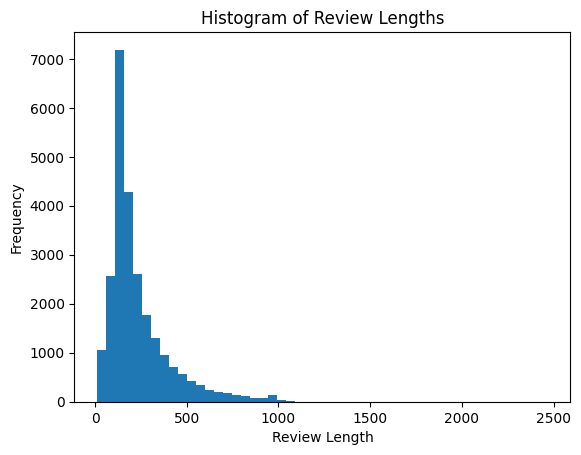

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def pad_sequence(reviews_tokenized, sequence_length):
    """
    Returns the tokenized review sequences padded with 0s or truncated to sequence_length.
    """
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype=int)

    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)

        if review_len <= sequence_length:
            # pad with zeros at the beginning
            zeroes = [0] * (sequence_length - review_len)
            new_sequence = zeroes + review
        else:
            # truncate if longer than sequence_length
            new_sequence = review[:sequence_length]

        padded_reviews[idx, :] = np.array(new_sequence)

    return padded_reviews

# Example usage
sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length)

# Plot histogram of review lengths
reviews_len = [len(review) for review in reviews_tokenized]
plt.hist(reviews_len, bins=50)
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Histogram of Review Lengths")
plt.show()


In [25]:
# Train-validation split
train_val_split = 0.75
split_idx = int(train_val_split * len(padded_reviews))

train_X = padded_reviews[:split_idx]
train_y = encoded_label_list[:split_idx]

validation_X = padded_reviews[split_idx:]
validation_y = encoded_label_list[split_idx:]


In [26]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert NumPy arrays to PyTorch tensors and move to device
train_dataset = TensorDataset(
    torch.from_numpy(train_X).to(device),
    torch.from_numpy(train_y).to(device)
)

validation_dataset = TensorDataset(
    torch.from_numpy(validation_X).to(device),
    torch.from_numpy(validation_y).to(device)
)

batch_size = 32

# Create PyTorch DataLoaders with shuffling for training
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=True
)


In [27]:
train_data_iter = iter(train_dataloader)

X_example, y_example = next(train_data_iter)
# batch_size, seq_length
print('Example Input size: ', X_example.size())
print('Example Input:\n', X_example)
print()
# batch_size
print('Example Output size: ', y_example.size())
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[   0,    0,    0,  ...,   48,   54, 1879],
        [   0,    0,    0,  ..., 1487,   45,    4],
        [   0,    0,    0,  ...,    1,  243,  119],
        ...,
        [   0,    0,    0,  ...,  203,    7,    8],
        [   0,    0,    0,  ...,   45,    4,  301],
        [   0,    0,    0,  ..., 3785,   21,    9]], device='cuda:0')

Example Output size:  torch.Size([32])
Example Output:
 tensor([0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')


In [28]:
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)

    def forward(self, sequence):
        embedding = self.embedding_layer(sequence)
        output, hidden_state = self.rnn_layer(embedding)
        final_output = self.fc_layer(hidden_state[-1, :, :].squeeze(0))
        return final_output

In [42]:
input_dimension = len(vocab_to_token)+1
# +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1
rnn_model = RNN(input_dimension, embedding_dimension,
hidden_dimension, output_dimension)
optim = torch.optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()
rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [43]:
def accuracy_metric(predictions, ground_truth):
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float()
    accuracy = success.sum() / len(success)
    return accuracy

In [44]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()

    for sequence, sentiment in dataloader:
        optim.zero_grad()
        preds = model(sequence.T).squeeze()
        loss_curr = loss_func(preds, sentiment)
        accuracy_curr = accuracy_metric(preds, sentiment)
        loss_curr.backward()
        optim.step()

        loss += loss_curr.item()
        accuracy += accuracy_curr.item()

    return loss / len(dataloader), accuracy / len(dataloader)

In [45]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()

    with torch.no_grad():
        for sequence, sentiment in dataloader:
            preds = model(sequence.T).squeeze()
            loss_curr = loss_func(preds, sentiment)
            accuracy_curr = accuracy_metric(preds, sentiment)

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()

    return loss / len(dataloader), accuracy / len(dataloader)

In [52]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):
    time_start = time.time()

    training_loss, train_accuracy = train(
        rnn_model,
        train_dataloader,
        optim,
        loss_func
    )

    validation_loss, validation_accuracy = validate(
        rnn_model,
        validation_dataloader,
        loss_func
    )

    time_end = time.time()
    time_delta = time_end - time_start

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')

    print(f'Epoch number: {ep+1} | Time elapsed: {time_delta:.2f}s')
    print(f'Training loss: {training_loss:.3f} | Training accuracy: {train_accuracy*100:.2f}%')
    print(f'Validation loss: {validation_loss:.3f} | Validation accuracy: {validation_accuracy*100:.2f}%')


Epoch number: 1 | Time elapsed: 4.79s
Training loss: 0.618 | Training accuracy: 66.83%
Validation loss: 1.067 | Validation accuracy: 24.78%
Epoch number: 2 | Time elapsed: 3.95s
Training loss: 0.514 | Training accuracy: 75.29%
Validation loss: 0.909 | Validation accuracy: 49.21%
Epoch number: 3 | Time elapsed: 4.02s
Training loss: 0.425 | Training accuracy: 81.32%
Validation loss: 0.827 | Validation accuracy: 57.01%
Epoch number: 4 | Time elapsed: 4.17s
Training loss: 0.426 | Training accuracy: 80.34%
Validation loss: 0.995 | Validation accuracy: 53.44%
Epoch number: 5 | Time elapsed: 3.96s
Training loss: 0.311 | Training accuracy: 87.48%
Validation loss: 0.836 | Validation accuracy: 66.70%
Epoch number: 6 | Time elapsed: 4.03s
Training loss: 0.326 | Training accuracy: 86.64%
Validation loss: 0.712 | Validation accuracy: 66.83%
Epoch number: 7 | Time elapsed: 4.17s
Training loss: 0.298 | Training accuracy: 88.29%
Validation loss: 1.303 | Validation accuracy: 49.31%
Epoch number: 8 | Ti

In [53]:
def sentiment_inference(model, sentence):
    model.eval()

    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512 - len(tokenized), 0), 'constant')

    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)

    pred = torch.sigmoid(model(model_input))
    return pred.item()

In [54]:
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I just really loved the movie"))

0.09114712476730347
0.6513257622718811
0.9965584874153137
0.9746956825256348
